## Adaptive Estimator
 - Circuit Used - EfficientSU2 Echo
 - Qubits Tested - [5, 20, 35, 45]
 - EMST available - Readout EM, DD, ZNE
 - Circuit Transpilation - Default transpiled with Optimization level = 3

In [1]:
import sys
import os

# Add project root (one level up from 'notebooks')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [2]:
from qiskit import QuantumCircuit
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorV2 as Estimator,
    EstimatorOptions,
    Batch,
)
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import efficient_su2
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendEstimatorV2
from adaptive_error_mitigation.analytics import (
    extract_basic_features,
    extract_backend_metrics,
    calculate_derived_noise_metrics,
)
from qiskit.providers.backend import BackendV2 as Backend
from adaptive_error_mitigation import adaptive_estimator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

In [3]:
def gen_param4_eff_su2(n_qubits: int, seed: int, reps: int = 1):
    np.random.seed(seed)
    arr = np.random.normal(loc=0, scale=0.22, size=n_qubits * reps * 4)
    return arr


def prepare_echo_eff_su2_with_xs(n_qubits: int, params: list):
    crkt = efficient_su2(num_qubits=n_qubits, reps=1, entanglement="linear")
    eff_su2_crkt = crkt.assign_parameters(params)

    # Loschmidt echo circuit: GHZ → barrier → GHZ† → measurement
    circuit = QuantumCircuit(n_qubits)
    circuit.compose(eff_su2_crkt, inplace=True)
    circuit.barrier()
    circuit.compose(eff_su2_crkt.inverse(), inplace=True)
    circuit.x(range(n_qubits))

    return circuit


def pm_for_backend(bknd, opt_level=3, seed=42069):
    ## Returns a PassManager from generate_preset_pass_manager for given opt_level and backend(bknd)
    pm = generate_preset_pass_manager(
        optimization_level=opt_level,
        backend=bknd,
        seed_transpiler=seed,
    )
    return pm


def create_isa_observables(isa_circuit_dict, pauli_char="Z"):
    ## Returns a dict of ISA observables with layouts applied, matching the input isa_circuit_dict keys.
    isa_observables = {}

    for key, isa_qc in isa_circuit_dict.items():
        # 1. Parse qubit count from key
        num_qubits = int(key)

        # 2. Create the logical observable (e.g., "ZZZ")
        observable = SparsePauliOp(pauli_char * num_qubits)

        # 3. Apply the layout from the transpiled circuit
        isa_obs = observable.apply_layout(isa_qc.layout)

        isa_observables[key] = isa_obs

    return isa_observables


def transpile_for_dd(circuit, dd_pm):
    isa_dd_circuit = dd_pm.run(circuit)
    return isa_dd_circuit


def get_h_zne(qc, backend):
    # 1. Extract required metrics using your helper functions
    qubits_used = extract_basic_features(qc)["qubits_used"]
    ons = calculate_derived_noise_metrics(qc, backend)["overall_noise_sensitivity"]
    t2_avg = extract_backend_metrics(qc, backend)["avg_t2_time"]

    # 2. Get circuit duration from the backend target
    duration_ns = qc.estimate_duration(backend.target)

    # 3. Calculate H_ZNE (Handling division by zero)
    if t2_avg == 0:
        return 0.0

    h_zne = ons + qubits_used * (duration_ns / t2_avg)
    return h_zne


# Helper function for circuit density
def get_density(qc):
    m = extract_basic_features(qc)
    # Avoid division by zero
    if m["qubits_used"] * m["depth"] == 0:
        return 0
    return (m["num_1q_gates"] + 2 * m["num_2q_gates"]) / (m["qubits_used"] * m["depth"])


# Function to get max. readout error
def get_max_rd_err(circuit, backend):
    backend_metrics = extract_backend_metrics(circuit, backend)
    max_readout_error = backend_metrics.get("max_readout_error", 0.0)
    return max_readout_error

In [4]:
# Backend
service = QiskitRuntimeService(name="qamp-2025")
bknd_fez = service.backend("ibm_fez")

management.get:WARNING:2025-12-15 12:08:19,473: Loading saved account: qamp-2025


In [10]:
QUBIT_SEED = [
    (5, 8),
    (20, 6367),
    (35, 8411),
    (45, 4697),
]

In [11]:
params_dict = {
    f"{n_qubits}": gen_param4_eff_su2(n_qubits, seed) for n_qubits, seed in QUBIT_SEED
}

In [12]:
## Prepare circuit dict
circuit_dict = {
    n_qubits: prepare_echo_eff_su2_with_xs(n_qubits=int(n_qubits), params=params)
    for n_qubits, params in params_dict.items()
}
circuit_dict

{'5': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1a150299d90>,
 '20': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1a1502ab3d0>,
 '35': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1a15242a990>,
 '45': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1a151ae7e50>}

In [13]:
## Transpiler with optimization_level=3
pm3 = pm_for_backend(bknd_fez)
isa_dict = {
    f"{n_qubits}": pm3.run(circuit_dict[f"{n_qubits}"]) for n_qubits, _ in QUBIT_SEED
}

In [14]:
obs_isa_dict = create_isa_observables(isa_dict, pauli_char="Z")

In [15]:
h_zne_dict = {f"{key}": get_h_zne(isa_qc, bknd_fez) for key, isa_qc in isa_dict.items()}
h_zne_dict

{'5': 0.08777605227183827,
 '20': 0.8662082057004301,
 '35': 2.5713197925705527,
 '45': 3.7809965668197223}

In [16]:
# Circuit density
cd_isa_qc_dict = {f"{q}": get_density(qc) for q, qc in isa_dict.items()}
cd_isa_qc_dict

{'5': 0.585,
 '20': 0.17448275862068965,
 '35': 0.1024,
 '45': 0.08027777777777778}

In [17]:
# Max. Readout error
max_readout_err_dict = {f"{q}": get_max_rd_err(qc, bknd_fez) for q, qc in isa_dict.items()}
max_readout_err_dict

{'5': 0.0260009765625,
 '20': 0.021728515625,
 '35': 0.04150390625,
 '45': 0.084716796875}

In [18]:
## Simulate on Aer Simulator
mps_backend = AerSimulator(method="matrix_product_state")
aer_estimator = BackendEstimatorV2(backend=mps_backend)

aer_pub = [
    (isa_dict[f"{n_qubit}"], obs_isa_dict[f"{n_qubit}"]) for n_qubit, _ in QUBIT_SEED
]

for n_qubit, _ in QUBIT_SEED:
    aer_job = aer_estimator.run(aer_pub)
    aer_result = aer_job.result()

ideal_est = {f"{n}": res.data.evs for (n, _), res in zip(QUBIT_SEED, aer_result)}
ideal_est

{'5': array(-1.), '20': array(1.), '35': array(-1.), '45': array(-1.)}

In [19]:
pub_hardware_dict = {f"{n}": [isa_dict[f"{n}"]] for n, _ in QUBIT_SEED}
pub_hardware_dict

{'5': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1a1526207d0>],
 '20': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1a1525982d0>],
 '35': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1a152637150>],
 '45': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1a152598990>]}

In [20]:
# --- 1. PREPARATION ---
all_pubs = []
result_map = []

# Iterate through your hardware dictionary
for qubit_count, circuit_list in pub_hardware_dict.items():

    # Get the observable for this specific qubit count
    # (We assume obs_isa_dict has keys like '5', '11', etc.)
    current_obs = obs_isa_dict[qubit_count]

    for i, circ in enumerate(circuit_list):
        # Safety: Sanitize Name
        circ.name = f"{qubit_count}q_isa_only"

        # Create PUB: (Circuit, Observable)
        pub = (circ, current_obs)
        all_pubs.append(pub)

        # Store metadata
        # Since you have no DD methods, we hardcode 'method' to 'Standard'
        result_map.append({"qubits": qubit_count, "method": "Standard_ISA"})

print(f"Total PUBs per job: {len(all_pubs)}")

Total PUBs per job: 4


In [21]:
# Store job objects to retrieve results later
batch_jobs = []
NUM_ITRS = 3

# Open the Batch Context
with Batch(backend=bknd_fez) as batch:
    # Initialize Estimator with the batch context
    def_est = Estimator(mode=batch)

    # 3. Loop for the iterations
    for i in range(NUM_ITRS):

        # Submit ALL pubs in ONE job
        # Note: all_pubs is already a list of (circuit, observable) tuples
        def_job = def_est.run(all_pubs)
        def_job_id = def_job.job_id()
        # def_job = f"job_id_def_est_itr{i}"
        print(
            f"\nSubmitted Job-ID via Default Estimator for iteration {i+1}/{NUM_ITRS}...: {def_job_id}\n"
        )
        # Store in batch_jobs with a tag so you can identify it later
        batch_jobs.append(
            {
                "type": "default",
                "job": def_job,
                "est_options": None,
            }
        )

        # -------------------------------------------------------
        # B. Adaptive Estimator (Runs 1 Job PER Pub)
        # -------------------------------------------------------
        # This returns a LIST of dictionaries: [{'job': job, 'est_options': opts}, ...]
        adapt_results_list = adaptive_estimator.run(
            all_pubs, mode=batch, backend=bknd_fez
        )

        # Loop through the list to handle each job individually
        for pub_idx, res_entry in enumerate(adapt_results_list):
            job_obj = res_entry["job"]

            print(
                f"Submitted Job-ID via Adaptive Estimator for Pub {pub_idx} (Iter {i+1}/{NUM_ITRS}) -> Job-ID: {job_obj.job_id()}"
            )

            # Add a type tag and append to your main list
            res_entry["type"] = "adaptive"
            batch_jobs.append(res_entry)

print("All jobs submitted. Waiting for results...")


Submitted Job-ID via Default Estimator for iteration 1/3...: d4vqtdeaec6c738smp10


--- Processing Pub 1/4 ---
--- Initiating Adaptive Error Mitigation and Suppression Framework ---

--> DEFAULT SETTING: Using Default Precision set to 0.015625 and default shots 4096

---> HEURISTIC TRIGGERED: Readout Error Threshold Exceeded
     | Metric: MAX READOUT ERROR - 0.0260 (on Qubit 91)
     | Threshold Set: 0.0100 (READOUT_ERROR_THRESHOLD (config.py))
---> ACTION TAKEN: ENABLED Measure Mitigation (TREX)
     | Resilience Level: 1
     | Measure Noise Learning (Randomizations): 32 (NUM_RANDOMIZATIONS (config.py))
---> ACTION TAKEN: ENABLED Measure Twirling
     | Twirling: Measure=True / Gates=False
     | **Derived Parameters:** shots_per_randomization set to 128 (Shots: 4096 (DEFAULT_SHOTS (config.py)) / Randomizations: 32 (NUM_RANDOMIZATIONS (config.py)))

---> Circuit not scheduled. Applying ALAP scheduling...

Final Estimator Options:
{'_VERSION': 2, 'max_execution_time': Unset, 'enviro

In [23]:
plot_data = []

# Global State Trackers
current_iteration = 0  # 1, 2, 3
adaptive_pub_index = 0  # 0 to 4 (tracks which circuit in the list we are on)

print(f"Processing {len(batch_jobs)} job entries...")

for entry in batch_jobs:

    # 1. Identify Job Type
    job_type = entry.get("type", "unknown")  # "default" or "adaptive"
    job = entry["job"]
    est_opts = entry.get("est_options", "Standard")

    # 2. Update Iteration State
    # LOGIC: The code submits Default -> Adaptive(s) -> Default -> Adaptive(s)
    # So, every time we hit a "default" job, it means a NEW iteration loop has started.
    if job_type == "default":
        current_iteration += 1
        adaptive_pub_index = 0  # Reset for the new batch of adaptive jobs
        mitigation_label = "Standard_ISA"
    else:
        mitigation_label = "Adaptive_Mitigation"
        # We are currently processing the Nth circuit in the adaptive sequence

    try:
        # Fetch results
        job_result = job.result()
        current_job_id = job.job_id()
    except Exception as e:
        print(f"Job {job.job_id()} failed: {e}")
        # CRITICAL: If an adaptive job fails, we must still increment the index
        # to ensure the NEXT job maps to the NEXT qubit correctly.
        if job_type == "adaptive":
            adaptive_pub_index += 1
        continue

    # 3. Iterate through Results inside the Job
    # Default Job -> has N results (one for each qubit)
    # Adaptive Job -> has 1 result (for specific qubit at adaptive_pub_index)

    for i, pub_result in enumerate(job_result):

        # --- MAPPING LOGIC ---
        if job_type == "default":
            # For default, result 'i' corresponds to result_map[i]
            map_idx = i
        else:
            # For adaptive, the single result [0] corresponds to result_map[adaptive_pub_index]
            map_idx = adaptive_pub_index

        # Safety Check
        if map_idx >= len(result_map):
            print(f"Index Error: map_idx {map_idx} out of range for result_map")
            continue

        # Get Metadata
        meta = result_map[map_idx]
        q_count = meta["qubits"]
        q_str = str(q_count)

        # 4. Extract Data & Calculate Error
        ev_exp = float(pub_result.data.evs)
        ev_ideal = float(ideal_est[q_str])
        abs_error = abs(ev_exp - ev_ideal)

        # 5. Retrieve Physics Metrics
        # (Assuming these dictionaries were pre-calculated as per your note)
        circuit_density = float(cd_isa_qc_dict.get(q_str, 0))
        h_zne_val = float(h_zne_dict.get(q_str, 0))
        max_ro_err = float(max_readout_err_dict.get(q_str, 0))

        # 6. Append to Plot Data
        plot_data.append(
            {
                "Label": f"{q_str}q",
                "Qubits": int(q_count),
                "Iteration": current_iteration,
                "Mitigation_Method": mitigation_label,  # The Hue for your boxplot
                "Abs_Error": abs_error,
                "Exp_Value": ev_exp,
                "Ideal_Value": ev_ideal,
                "Circuit_Density": circuit_density,
                "H_ZNE_Score": h_zne_val,
                "Max_Readout_Err": max_ro_err,
                "Estimator_Options": str(est_opts),
                "Job_ID": current_job_id,
            }
        )

    # 7. Post-Processing for Adaptive Jobs
    # After we finish processing the single result of an adaptive job,
    # we must increment the tracker so the NEXT adaptive job grabs the NEXT qubit's metadata.
    if job_type == "adaptive":
        adaptive_pub_index += 1

# Create DataFrame
df = pd.DataFrame(plot_data)

# Sort for cleaner inspection
df = df.sort_values(by=["Qubits", "Mitigation_Method", "Iteration"]).reset_index(
    drop=True
)

print("Analysis Complete.")
print(df.head(10))

Processing 15 job entries...
Analysis Complete.
  Label  Qubits  Iteration    Mitigation_Method  Abs_Error  Exp_Value  \
0    5q       5          1  Adaptive_Mitigation   0.131264  -0.868736   
1    5q       5          2  Adaptive_Mitigation   0.134209  -0.865791   
2    5q       5          3  Adaptive_Mitigation   0.148693  -0.851307   
3    5q       5          1         Standard_ISA   0.036898  -0.963102   
4    5q       5          2         Standard_ISA   0.044074  -0.955926   
5    5q       5          3         Standard_ISA   0.037879  -0.962121   
6   20q      20          1  Adaptive_Mitigation   0.533811   0.466189   
7   20q      20          2  Adaptive_Mitigation   0.503147   0.496853   
8   20q      20          3  Adaptive_Mitigation   0.464232   0.535768   
9   20q      20          1         Standard_ISA   0.519582   0.480418   

   Ideal_Value  Circuit_Density  H_ZNE_Score  Max_Readout_Err  \
0         -1.0         0.585000     0.087776         0.026001   
1         -1.0    

In [24]:
# Saves the file to the same folder as your notebook
df.to_csv("AE_Batch_Est_EffSU2_Echo_4.csv", index=False)

In [4]:
# df = pd.read_csv("AE_GT_Batch_Est_2.csv")
df_1 = pd.read_csv("AE_Batch_Est_EffSU2_Echo_3.csv")
df = pd.read_csv("AE_Batch_Est_EffSU2_Echo_4.csv")

In [5]:
# 1. Create a list of the dataframes you want to combine
frames = [df, df_1]

# 2. Concatenate them
# ignore_index=True ensures the index resets to 0, 1, 2... continuously
df = pd.concat(frames, ignore_index=True)

# 3. (Optional but Recommended) Re-sort so the new data sits in the right place
df = df.sort_values(by=["Qubits", "Mitigation_Method", "Iteration"]).reset_index(
    drop=True
)

# Check the result
print(f"New shape: {df.shape}")
df.head()

New shape: (48, 12)


,Label,Qubits,Iteration,Mitigation_Method,Abs_Error,Exp_Value,Ideal_Value,Circuit_Density,H_ZNE_Score,Max_Readout_Err,Estimator_Options,Job_ID
0,5q,5,1,Adaptive_Est.,0.131264,-0.868736,-1,0.585,0.087776,0.026001,"EstimatorOptions(_VERSION=2, max_execution_tim...",d4vqtdmaec6c738smp1g
1,5q,5,2,Adaptive_Est.,0.134209,-0.865791,-1,0.585,0.087776,0.026001,"EstimatorOptions(_VERSION=2, max_execution_tim...",d4vqtf7g0u6s73db3lu0
2,5q,5,3,Adaptive_Est.,0.148693,-0.851307,-1,0.585,0.087776,0.026001,"EstimatorOptions(_VERSION=2, max_execution_tim...",d4vqtgsgk3fc73av9v6g
3,5q,5,1,Default_IBM_Est.,0.036898,-0.963102,-1,0.585,0.087776,0.026001,NaN,d4vqtdeaec6c738smp10
4,5q,5,2,Default_IBM_Est.,0.044074,-0.955926,-1,0.585,0.087776,0.026001,NaN,d4vqteteastc73cihob0


In [6]:
# Keep rows where Abs_Error is LESS than or equal to 2
df = df[df["Abs_Error"] <= 2]

# Reset the index to avoid gaps
df = df.reset_index(drop=True)

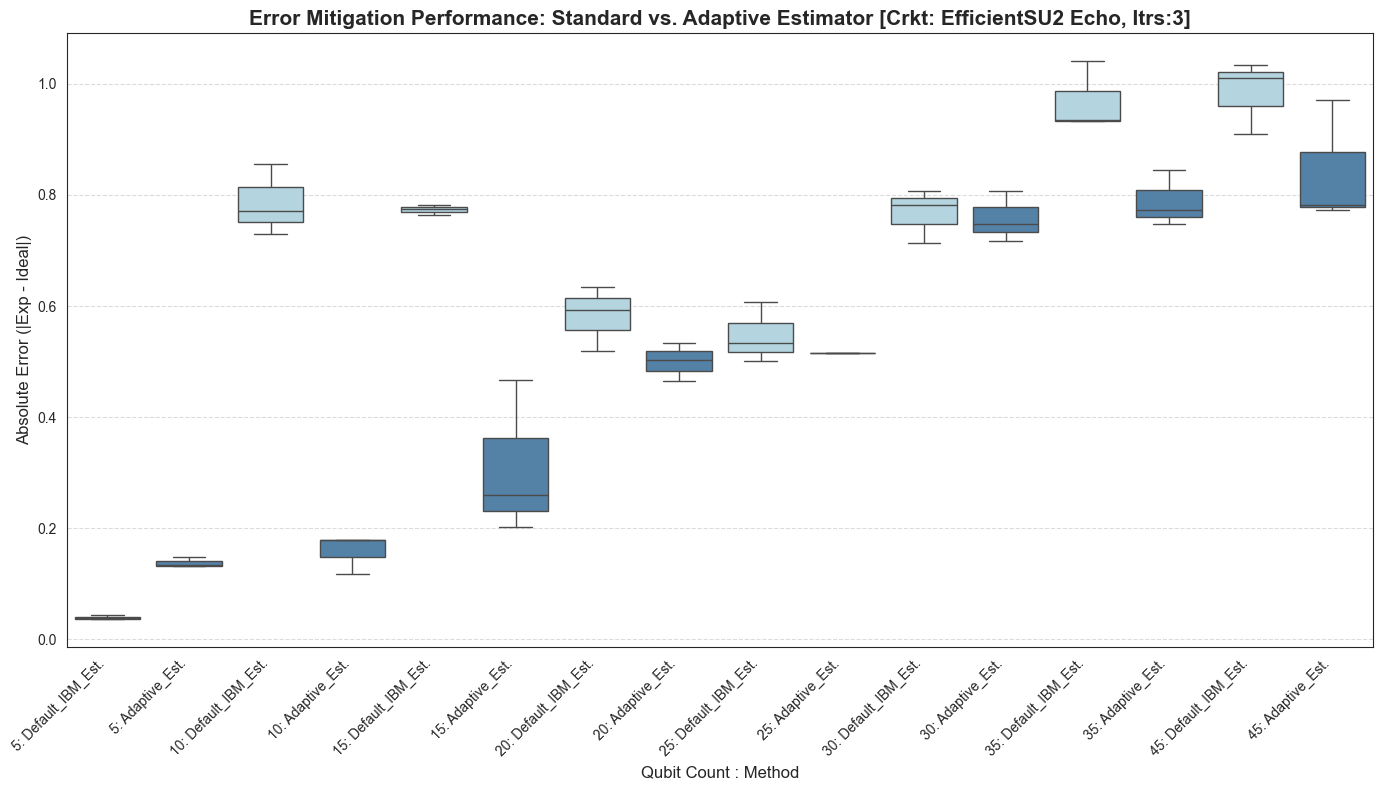

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preparation
# Create a combined label column: e.g., "5: Standard_ISA", "5: Adaptive_Mitigation"
# We use the new column name "Mitigation_Method"
df["Label"] = df["Qubits"].astype(str) + ": " + df["Mitigation_Method"]

# Sort the dataframe by integer Qubits first, then by Method
# This ensures 5 qubits comes before 27, 127, etc.
df = df.sort_values(by=["Qubits", "Mitigation_Method"], ascending=[True, False])

# 2. Setup Figure
plt.figure(figsize=(14, 8))
sns.set_style("white")  # Cleaner background

# 3. Define Colors and Palette Logic
# Update keys to match the actual values in your new dataframe
# Standard_ISA -> Light Blue (Baseline)
# Adaptive_Mitigation -> Steel Blue (Mitigated)
color_map = {"Default_IBM_Est.": "#ADD8E6", "Adaptive_Est.": "#4682B4"}

# Get unique labels in the exact order they appear in the sorted dataframe
unique_labels = df["Label"].unique()

# Generate the palette list matching the sorted labels
# We split the label string by ": " to retrieve the method name for mapping
palette_list = [color_map[label.split(": ")[1]] for label in unique_labels]

# 4. Create the Box Plot
sns.boxplot(
    data=df,
    x="Label",
    y="Abs_Error",
    hue="Label",  # Assign hue to Label to apply the specific palette
    palette=palette_list,
    dodge=False,  # Prevents shifting; bars sit side-by-side naturally due to x-axis
    legend=False,  # Legend is redundant
    fliersize=3,  # Keep outlier dots small
)

# 5. Titles and Labels
plt.title(
    "Error Mitigation Performance: Standard vs. Adaptive Estimator [Crkt: EfficientSU2 Echo, Itrs:3]",
    fontsize=15,
    fontweight="bold",
)
plt.xlabel("Qubit Count : Method", fontsize=12)
plt.ylabel("Absolute Error (|Exp - Ideal|)", fontsize=12)

# 6. Adjust Axes and Grid
# Dynamic Y-limits with a 5% buffer
min_y = df["Abs_Error"].min()
max_y = df["Abs_Error"].max()
buffer = (max_y - min_y) * 0.05
plt.ylim(min_y - buffer, max_y + buffer)

# Grid only on Y-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-labels for readability
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig("adaptive_comparison_flat.png", dpi=300)
plt.show()

In [30]:
# 1. Group by Qubits and Mitigation_Method to get the MEAN Absolute Error across iterations
# We use the new column name "Mitigation_Method"
df_avg = df.groupby(["Qubits", "Mitigation_Method"])["Abs_Error"].mean().unstack()

# 2. Calculate "Improvement" (Positive means Adaptive method reduced the error)
# New Logic: Standard_ISA (Baseline) - Adaptive_Mitigation (Optimized)
df_avg["Improvement"] = df_avg["Standard_ISA"] - df_avg["Adaptive_Mitigation"]

# 3. Map your Custom Metrics
# We use the column names available in the df created in previous steps
df_avg["H_ZNE_Score"] = df.groupby("Qubits")["H_ZNE_Score"].first()
df_avg["Circuit_Density"] = df.groupby("Qubits")["Circuit_Density"].first()
df_avg["Max_Readout_Err"] = df.groupby("Qubits")["Max_Readout_Err"].first()

# Reset index so 'Qubits' becomes a regular column for plotting
df_analysis = df_avg.reset_index()

# Check the data
print(df_analysis[["Qubits", "Improvement", "H_ZNE_Score", "Circuit_Density"]])

Mitigation_Method  Qubits  Improvement  H_ZNE_Score  Circuit_Density
0                       5    -0.098438     0.087776         0.585000
1                      10     0.627332     0.229708         0.329333
2                      15     0.462808     0.567541         0.228485
3                      20     0.082274     0.866208         0.174483
4                      25     0.031145     1.270849         0.141333
5                      30     0.010023     1.884223         0.118760
6                      35     0.180838     2.571320         0.102400
7                      45     0.142079     3.780997         0.080278


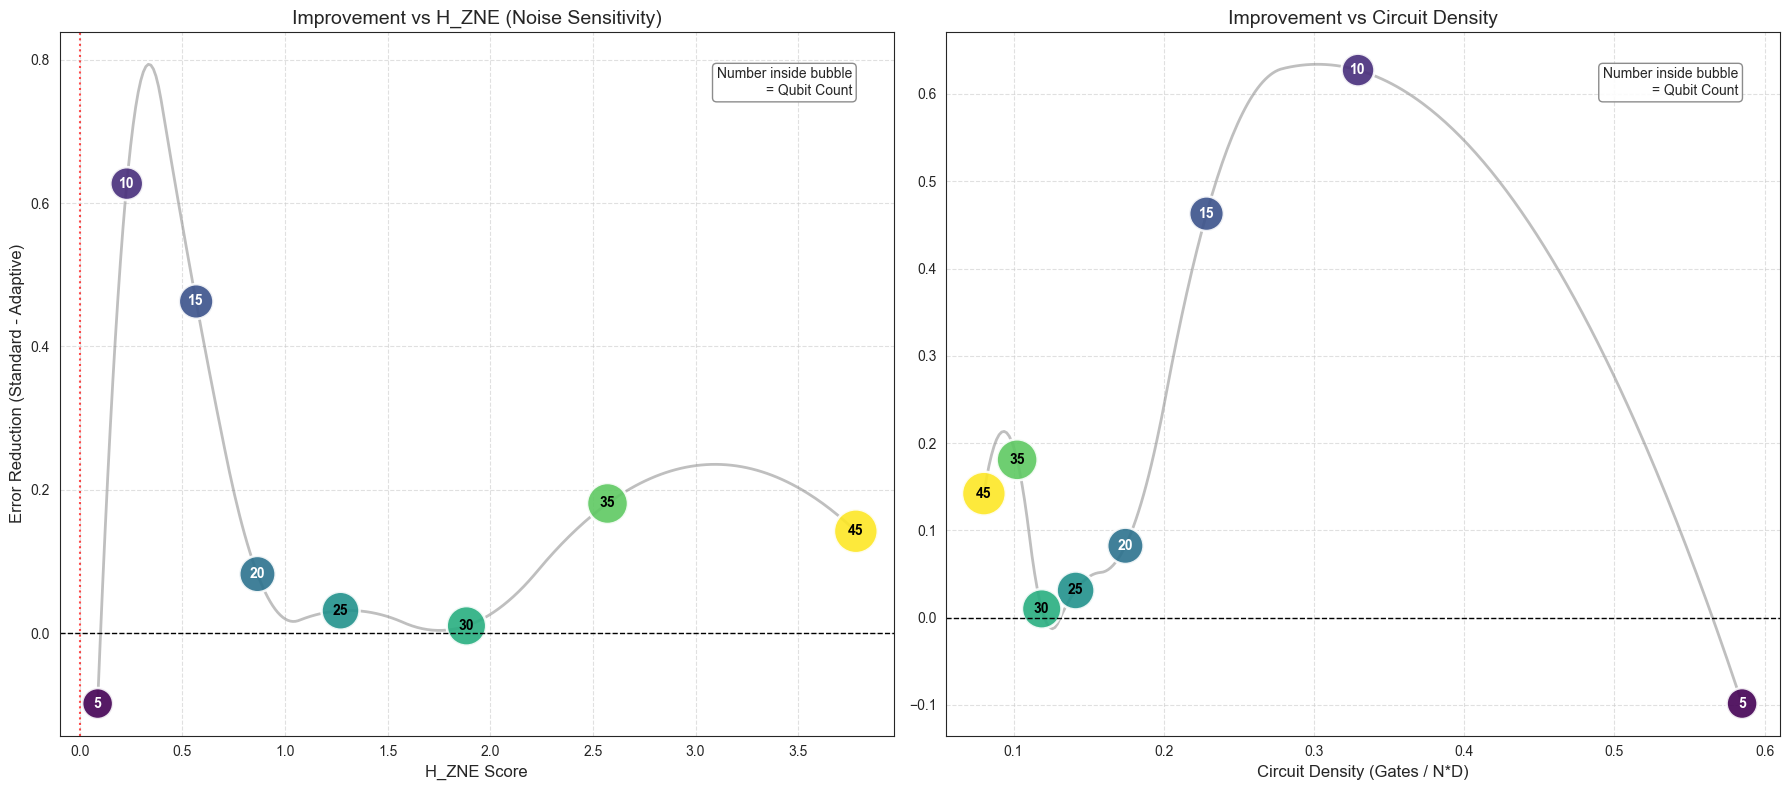

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline

# Setup the figure
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")


# Function to generate smooth curve data
def get_smooth_curve(x_data, y_data, k=2, n_points=300):
    # Sort data to prevent spline errors
    sorted_indices = np.argsort(x_data)
    x_sorted = x_data.iloc[sorted_indices]
    y_sorted = y_data.iloc[sorted_indices]

    # Handle duplicates (spline requires unique x)
    x_unique, unique_indices = np.unique(x_sorted, return_index=True)
    y_unique = y_sorted.iloc[unique_indices]

    if len(x_unique) < k + 1:
        return x_unique, y_unique

    x_new = np.linspace(x_unique.min(), x_unique.max(), n_points)
    try:
        spl = make_interp_spline(x_unique, y_unique, k=k)
        y_smooth = spl(x_new)
        return x_new, y_smooth
    except Exception:
        return x_unique, y_unique


# ==============================================================================
# PLOT 1: Improvement vs H_ZNE_Score
# ==============================================================================

# 1. Add SMOOTH connecting line
df_sorted_1 = df_analysis.sort_values("H_ZNE_Score")
x_smooth_1, y_smooth_1 = get_smooth_curve(
    df_sorted_1["H_ZNE_Score"], df_sorted_1["Improvement"]
)
axes[0].plot(x_smooth_1, y_smooth_1, color="gray", linewidth=2, alpha=0.5, zorder=1)

# 2. Scatter Plot (Template Style)
sns.scatterplot(
    data=df_analysis,
    x="H_ZNE_Score",
    y="Improvement",
    hue="Qubits",
    palette="viridis",
    size="Qubits",
    sizes=(500, 1000),  # Large bubbles to accommodate text
    ax=axes[0],
    legend=False,  # Legend removed, using text inside bubbles instead
    zorder=2,
    alpha=0.9,
)

# 3. Add Qubit numbers INSIDE bubbles
for i in range(df_analysis.shape[0]):
    x_pos = df_analysis["H_ZNE_Score"].iloc[i]
    y_pos = df_analysis["Improvement"].iloc[i]
    qubit_val = int(df_analysis["Qubits"].iloc[i])

    # Dynamic text color for contrast
    text_color = "white" if qubit_val < df_analysis["Qubits"].median() else "black"

    axes[0].text(
        x_pos,
        y_pos,
        str(qubit_val),
        horizontalalignment="center",
        verticalalignment="center",
        size="medium",
        color=text_color,
        weight="bold",
    )

# 4. Legend Box
axes[0].text(
    0.95,
    0.95,
    "Number inside bubble\n= Qubit Count",
    transform=axes[0].transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9, edgecolor="gray"),
)

# 5. Formatting
axes[0].axhline(0, color="black", linewidth=1, linestyle="--")
axes[0].axvline(0, color="red", linestyle=":", linewidth=1.5, alpha=0.7)
axes[0].set_title("Improvement vs H_ZNE (Noise Sensitivity)", fontsize=14)
axes[0].set_xlabel("H_ZNE Score", fontsize=12)
axes[0].set_ylabel("Error Reduction (Standard - Adaptive)", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.6)


# ==============================================================================
# PLOT 2: Improvement vs Circuit Density
# ==============================================================================

# 1. Add SMOOTH connecting line
df_sorted_2 = df_analysis.sort_values("Circuit_Density")
x_smooth_2, y_smooth_2 = get_smooth_curve(
    df_sorted_2["Circuit_Density"], df_sorted_2["Improvement"]
)
axes[1].plot(x_smooth_2, y_smooth_2, color="gray", linewidth=2, alpha=0.5, zorder=1)

# 2. Scatter Plot (Template Style)
sns.scatterplot(
    data=df_analysis,
    x="Circuit_Density",
    y="Improvement",
    hue="Qubits",
    palette="viridis",
    size="Qubits",
    sizes=(500, 1000),  # Large bubbles
    ax=axes[1],
    legend=False,
    zorder=2,
    alpha=0.9,
)

# 3. Add Qubit numbers INSIDE bubbles
for i in range(df_analysis.shape[0]):
    x_pos = df_analysis["Circuit_Density"].iloc[i]
    y_pos = df_analysis["Improvement"].iloc[i]
    qubit_val = int(df_analysis["Qubits"].iloc[i])

    # Dynamic text color
    text_color = "white" if qubit_val < df_analysis["Qubits"].median() else "black"

    axes[1].text(
        x_pos,
        y_pos,
        str(qubit_val),
        horizontalalignment="center",
        verticalalignment="center",
        size="medium",
        color=text_color,
        weight="bold",
    )

# 4. Legend Box (Optional, repeated for clarity)
axes[1].text(
    0.95,
    0.95,
    "Number inside bubble\n= Qubit Count",
    transform=axes[1].transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9, edgecolor="gray"),
)

# 5. Formatting
axes[1].set_title("Improvement vs Circuit Density", fontsize=14)
axes[1].set_xlabel("Circuit Density (Gates / N*D)", fontsize=12)
axes[1].set_ylabel("")  # Redundant label removed
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].axhline(0, color="black", linewidth=1, linestyle="--")

plt.tight_layout()
plt.show()